# Infrared Absorption by the Atmosphere

<i>© Von P. Walden, Washington State University</i>

In [327]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Definition of the Optical Depth

To calculate the infrared absorption by the atmosphere, we must calculate the optical depth.  The optical depth is related to the transmission of radiation through "optical media", such as an absorbing gas or an absorbing liquid. [Beer's Law](https://en.wikipedia.org/wiki/Beer–Lambert_law) gives us

$$ I(\lambda) = I_o(\lambda) e^{-\tau} $$

This can be rewritten as 

$$ Transmission = \frac{I(\lambda)}{I_o(\lambda)} = e^{-\tau} $$

Then one can solve for the optical depth $\tau$ as

$$ \tau = -ln \Big[ \frac{I(\lambda)}{I_o(\lambda)} \Big] $$


In general, the optical depth is:

$$ \tau = \int_{z_1}^{z_2} \beta_{\lambda} dz = \int_{z_1}^{z_2} \kappa_{\lambda} \rho (z) dz = \int_{z_1}^{z_2} \sigma_{\lambda} n(z) dz $$

where 
- $\beta$ is the volume absorption coefficient,
- $\kappa$ is the mass absorption coefficient, 
- $\sigma$ is the absorption cross section,

which all depend on wavelength, $\lambda$.

$\rho(z)$ and n(z) are the air density and the number density of the absorbing gas. z is distance along the absorbing path from $z_1$ to $z_2$. 

If one conducts an experiment of Beer's Law in the lab using a tube filled with an absorbing gas (like H2O or CO2), this equation reduces to:

$$ \tau = \beta (z_2 - z_1) = \kappa_{\lambda} \rho (z_2 - z_1) = \sigma_{\lambda} N (z_2 - z_1) $$

Note that this is how scientists (100 or so years ago) determined how different gases absorbed infrared radiation at different wavelengths, by measuring the transmission of radiation through the gas, calculating the optical depth, then solving for either $\beta_{\lambda}$, $\kappa_{\lambda}$, or $\sigma_{\lambda}$.


### Optical Depth in the Atmosphere

To determine the optical depth in the atmosphere, one must use the general equation above, because the number of molecules of absorbing gas changes with height in the atmosphere. Carbon dioxide is "uniformly mixed" in the atmosphere, meaning that its concentration relative to other gases does not change with height. However, the actual number of CO2 molecules decreases exponentially with height in the atmosphere because the density (and pressure) of the air decreases in this manner. Most of the water vapor in the atmosphere is contained only in the troposphere in the lowest 7 or 8 km. Therefore, one must integrate through the atmosphere to determine the optical depth using: 

$$ \tau = \int_{z_1}^{z_2} \kappa_{\lambda} \rho (z) dz $$

Here we have chosen to use the specific formula of the optical depth that contains the mass absorption coefficient, because Figure 2 of  Pierrehumbert (2010) gives values of $\kappa$ for both H2O and CO2.


## The McClatchey Standard Atmospheres

We're lucky because [McClatchey et al (1972)](https://apps.dtic.mil/sti/pdfs/AD0753075.pdf) [in Optical Properties of the Atmosphere (Third Edition)] created a series of "standard atmospheres" for different locations and seasons on Earth that give us n(z) as a function of altitude (z) in the atmosphere. The McClatchey Standard Atmospheres are for:

- Tropics             (TRP)
- Mid-latitude Summer (MLS)
- Mid-latitude Winter (MLW)
- Sub-Arctic Summer   (SAS)
- Sub-Arctic Winter   (SAW


In [328]:
# Read in raw data files
columns = ['layer', 'altitude', 'pressure', 'temperature', 'dew_point', 'density', 'h2o', 'co2', 'o3', 'n2o', 'co', 'ch4', 'o2']
trp = pd.read_table('../trp.dat', sep='\s+', names=columns)
mls = pd.read_table('../mls.dat', sep='\s+', names=columns)
mlw = pd.read_table('../mlw.dat', sep='\s+', names=columns)
sas = pd.read_table('../sas.dat', sep='\s+', names=columns)
saw = pd.read_table('../saw.dat', sep='\s+', names=columns)

In [329]:
Rair = 287.058        # J kg-1 K-1
# Calculate air density
trp.rename({'density': 'numberDensity'})
trp['airDensity'] = (trp.pressure * 100) / (Rair * trp.temperature)

mls.rename({'density': 'numberDensity'})
mls['airDensity'] = (mls.pressure * 100) / (Rair * mls.temperature)

mlw.rename({'density': 'numberDensity'})
mlw['airDensity'] = (mlw.pressure * 100) / (Rair * mlw.temperature)

sas.rename({'density': 'numberDensity'})
sas['airDensity'] = (sas.pressure * 100) / (Rair * sas.temperature)

saw.rename({'density': 'numberDensity'})
saw['airDensity'] = (saw.pressure * 100) / (Rair * saw.temperature)


In [330]:
# Interpolate the standard atmospheres to a common grid in meters with heights every 100 meters
trp.index = trp.altitude*1000
trp = trp.reindex(np.arange(0,60001,100)).interpolate(method='linear')

mls.index = mls.altitude*1000
mls = mls.reindex(np.arange(0,60001,100)).interpolate(method='linear')

mlw.index = mlw.altitude*1000
mlw = mlw.reindex(np.arange(0,60001,100)).interpolate(method='linear')

sas.index = sas.altitude*1000
sas = sas.reindex(np.arange(0,60001,100)).interpolate(method='linear')

saw.index = saw.altitude*1000
saw = saw.reindex(np.arange(0,60001,100)).interpolate(method='linear')

---

## 1) Choose the standard atmosphere

| Standard Atmosphere | stdatm_name |
| ------------------- | ----------- |
| Tropical            |    'trp'    |
| Mid-Latitude Summer |    'mls'    |
| Mid-Latitude Winter |    'mlw'    |
| Sub-Arctic Summer   |    'sas'    |
| Sub-Arctic Winter   |    'saw'    |

In [331]:
# Change this variable to choose the model atmosphere
# !! NOTE that the single quotation marks are important !!

stdatm_name = 'mlw'

if 'trp' in stdatm_name:
    stdatm = trp
elif 'mls' in stdatm_name:
    stdatm = mls
elif 'mlw' in stdatm_name:
    stdatm = mlw
elif 'sas' in stdatm_name:
    stdatm = sas
elif 'saw' in stdatm_name:
    stdatm = saw
else:
    print("ERROR: This standard atmosphere is NOT RECOGNIZED. Try setting stdatm_name again!!")

## 2) Set the atmospheric CO2 concentration (in ppmv)

In [332]:
# Set CO2 in all Standard Atmospheres.
co2 = 330.   # ppmv; approximate concentration in 1971
#co2 = 419.   # ppmv; current concentration in 2023
#co2 = 280.   # ppmv; pre-industrial concentration
#co2 = 560.   # ppmv; doubled CO2 concentration (from pre-industrial)

trp['co2'] = mls['co2'] = mlw['co2'] = sas['co2'] = saw['co2'] = co2

---

### Pressure, Temperature, and Air Density in the Standard Atmospheres

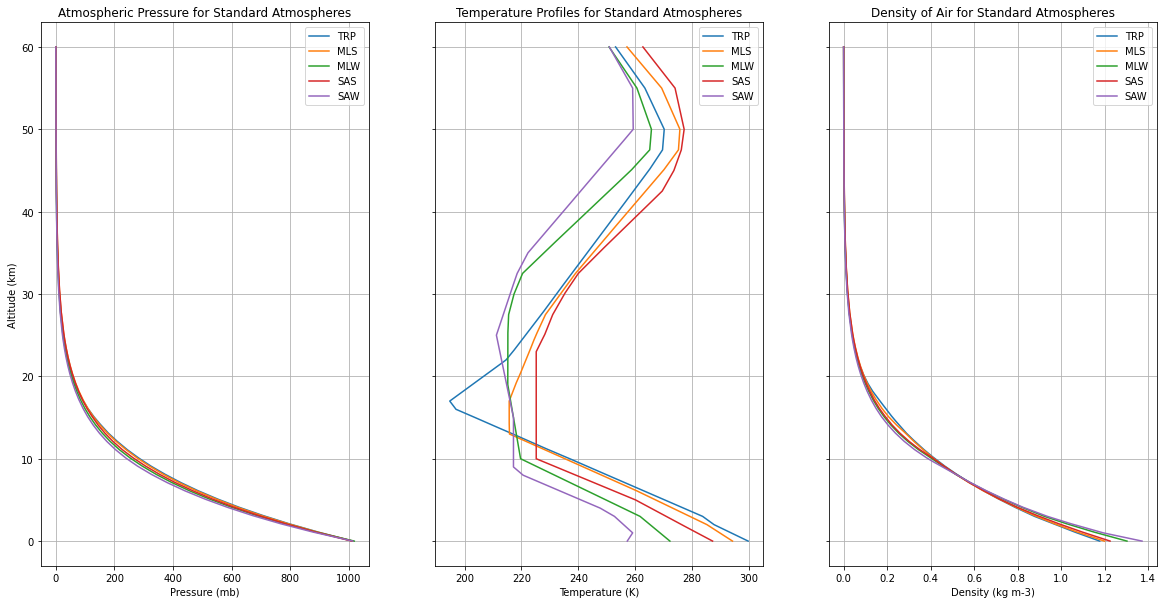

In [333]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,10), nrows=1, ncols=3, sharey=True)

# Pressure
trp.plot(ax=ax1, x='pressure', y='altitude')
mls.plot(ax=ax1, x='pressure', y='altitude')
mlw.plot(ax=ax1, x='pressure', y='altitude')
sas.plot(ax=ax1, x='pressure', y='altitude')
saw.plot(ax=ax1, x='pressure', y='altitude')
ax1.grid()
ax1.set_xlabel('Pressure (mb)');
ax1.set_ylabel('Altitude (km)');
ax1.set_title('Atmospheric Pressure for Standard Atmospheres');
ax1.legend(['TRP','MLS','MLW','SAS','SAW']);

# Temperature
trp.plot(ax=ax2, x='temperature', y='altitude')
mls.plot(ax=ax2, x='temperature', y='altitude')
mlw.plot(ax=ax2, x='temperature', y='altitude')
sas.plot(ax=ax2, x='temperature', y='altitude')
saw.plot(ax=ax2, x='temperature', y='altitude')
ax2.grid()
ax2.set_xlabel('Temperature (K)');
ax2.set_ylabel('Altitude (km)');
ax2.set_title('Temperature Profiles for Standard Atmospheres');
ax2.legend(['TRP','MLS','MLW','SAS','SAW']);

#O3
trp.plot(ax=ax3, x='airDensity', y='altitude')
mls.plot(ax=ax3, x='airDensity', y='altitude')
mlw.plot(ax=ax3, x='airDensity', y='altitude')
sas.plot(ax=ax3, x='airDensity', y='altitude')
saw.plot(ax=ax3, x='airDensity', y='altitude')
ax3.grid()
ax3.set_xlabel('Density (kg m-3)');
ax3.set_ylabel('Altitude (km)');
ax3.set_title('Density of Air for Standard Atmospheres');
ax3.legend(['TRP','MLS','MLW','SAS','SAW']);

### Primary Greenhouse Gas Concentrations in Standard Atmospheres

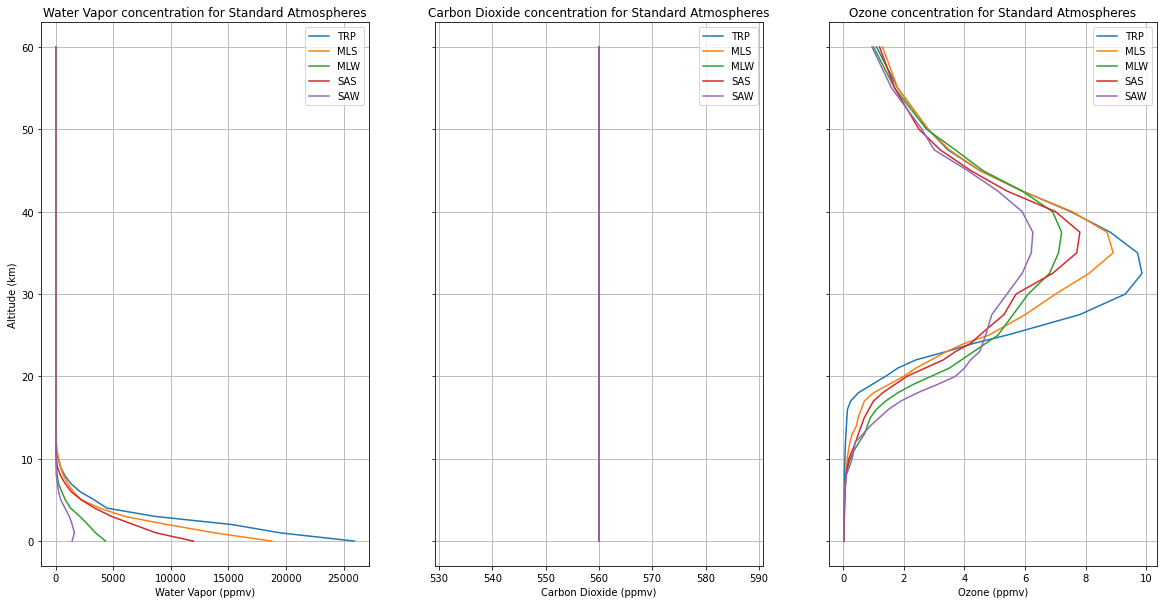

In [334]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(20,10), nrows=1, ncols=3, sharey=True)

# H2O
trp.plot(ax=ax1, x='h2o', y='altitude')
mls.plot(ax=ax1, x='h2o', y='altitude')
mlw.plot(ax=ax1, x='h2o', y='altitude')
sas.plot(ax=ax1, x='h2o', y='altitude')
saw.plot(ax=ax1, x='h2o', y='altitude')
ax1.grid()
ax1.set_xlabel('Water Vapor (ppmv)');
ax1.set_ylabel('Altitude (km)');
ax1.set_title('Water Vapor concentration for Standard Atmospheres');
ax1.legend(['TRP','MLS','MLW','SAS','SAW']);

# CO2
trp.plot(ax=ax2, x='co2', y='altitude')
mls.plot(ax=ax2, x='co2', y='altitude')
mlw.plot(ax=ax2, x='co2', y='altitude')
sas.plot(ax=ax2, x='co2', y='altitude')
saw.plot(ax=ax2, x='co2', y='altitude')
ax2.grid()
ax2.set_xlabel('Carbon Dioxide (ppmv)');
ax2.set_ylabel('Altitude (km)');
ax2.set_title('Carbon Dioxide concentration for Standard Atmospheres');
ax2.legend(['TRP','MLS','MLW','SAS','SAW']);

#O3
trp.plot(ax=ax3, x='o3', y='altitude')
mls.plot(ax=ax3, x='o3', y='altitude')
mlw.plot(ax=ax3, x='o3', y='altitude')
sas.plot(ax=ax3, x='o3', y='altitude')
saw.plot(ax=ax3, x='o3', y='altitude')
ax3.grid()
ax3.set_xlabel('Ozone (ppmv)');
ax3.set_ylabel('Altitude (km)');
ax3.set_title('Ozone concentration for Standard Atmospheres');
ax3.legend(['TRP','MLS','MLW','SAS','SAW']);

## Calculating Optical Depth

Now that we have values for the air density and the concentrations of the greenhouse gases, it is easy to calculate the optical depth for individual gases. 

We will use mass absorption coefficients for carbon dioxide at the following wavelengths (from the center of the 15-um CO2 band towards the atmospheric window between 8 and 12.5 um):

|Type of Absorption|Wavenumber ($cm^{-1}$)|Wavelength ($\mu$m)| $\kappa_a$ ($m^2 kg^{-1}$) |
| ---------------- | -------------------- | ----------------- | -------------------------- |
| Very Strong      | 667                  | 15                | 2000                       |
| Very Strong      | 714                  | 14                |   10                       |
| Moderate         | 769                  | 13                |    0.1                     |
| Weak             | 833                  | 12                |    0.001                   |

These mass absorption coefficients values were *approximated* from Figure 2 in Pierrehumbert, Physics Today, January 2011. 

So, the optical depth can now be calculated for each layer of the atmosphere by multiplying the absorption cross sections ($\kappa_a$) by the air density, and then by the thickness of the atmospheric layer, as shown in the code below (for the Mid-latitude Winter Standard Atmosphere - MLW).

**Disclaimer:** Please note that this calculation of optical depth is for illustrative purposes only, and is over-simplified in the following ways:

- In most cases H2O overlaps the absorption bands of all the other GH gases. (See Figure 2 of Pierrehumbert (2010); blowup of 600-670 cm-1).

- We are neglecting how the line strengths of absorption lines depend on temperature in the atmosphere (https://hitran.org/docs/definitions-and-units/)

- We are neglecting how the widths of absorption lines depend on both temperature and pressure (https://hitran.org/docs/definitions-and-units/)

Accurate radiative transfer models of the atmosphere account for all of this issues.

In [335]:
Ka_15 = 2000
Ka_14 = 10
Ka_13 = 0.1
Ka_12 = 0.001

rhoCO2 = stdatm.airDensity[:-1] * stdatm.co2[:-1]/1e6     # Convert from ppmv to percent fraction
dz   = np.diff(stdatm.altitude) * 1000                 # Calculate the height of each layer by differencing levels; meters

# Calculate and plot the optical depth at 14.6 um for CO2 for the MLW Standard Atmosphere.
stdatm['od_15'] = Ka_15 * rhoCO2 * dz
stdatm['od_14'] = Ka_14 * rhoCO2 * dz
stdatm['od_13'] = Ka_13 * rhoCO2 * dz
stdatm['od_12'] = Ka_12 * rhoCO2 * dz

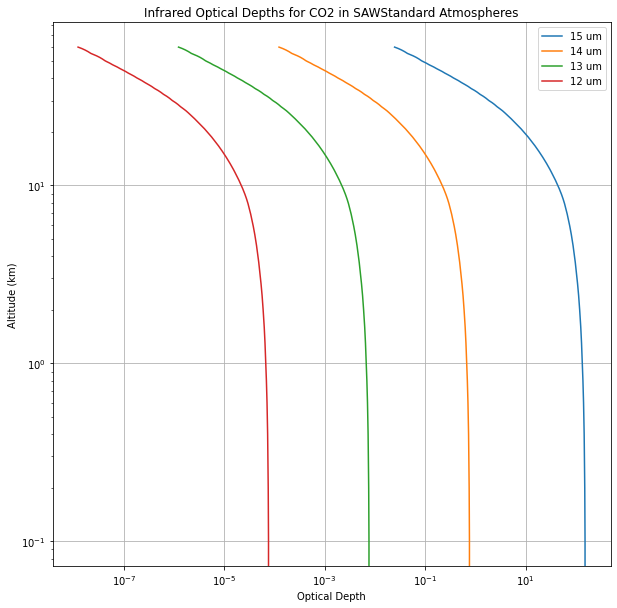

In [336]:
fig, ax = plt.subplots(figsize=(10,10))

stdatm.plot(ax=ax, x='od_15', y='altitude', logx=True, logy=True)
stdatm.plot(ax=ax, x='od_14', y='altitude', logx=True, logy=True)
stdatm.plot(ax=ax, x='od_13', y='altitude', logx=True, logy=True)
stdatm.plot(ax=ax, x='od_12', y='altitude', logx=True, logy=True)
ax.grid()
ax.set_xlabel('Optical Depth');
ax.set_ylabel('Altitude (km)');
ax.set_title('Infrared Optical Depths for CO2 in ' + stdatm_name + 'Standard Atmospheres');
ax.legend(['15 um','14 um','13 um','12 um']);

## Calculating Atmospheric Transmission

### As a function of altitude

In [337]:
stdatm['T_15'] = np.exp(-stdatm.od_15) * 100
stdatm['T_14'] = np.exp(-stdatm.od_14) * 100
stdatm['T_13'] = np.exp(-stdatm.od_13) * 100
stdatm['T_12'] = np.exp(-stdatm.od_12) * 100

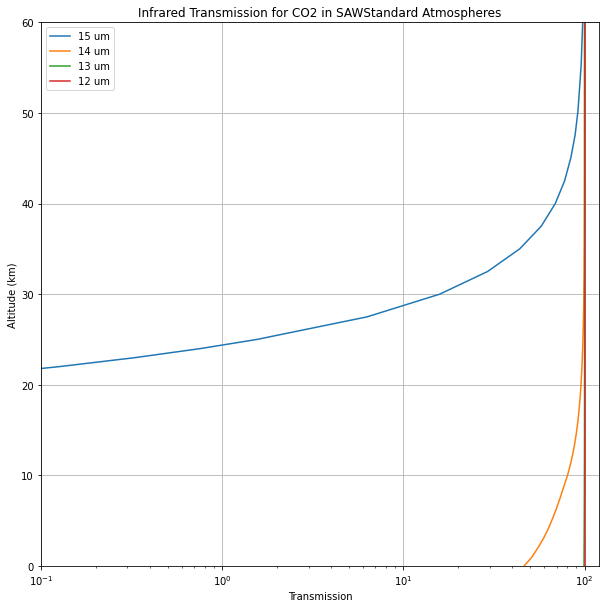

In [338]:
fig, ax = plt.subplots(figsize=(10,10))

stdatm.plot(ax=ax, x='T_15', y='altitude', logx=True)
stdatm.plot(ax=ax, x='T_14', y='altitude', logx=True)
stdatm.plot(ax=ax, x='T_13', y='altitude', logx=True)
stdatm.plot(ax=ax, x='T_12', y='altitude', logx=True)
ax.axis([0.1, 120, 0, 60])
ax.grid()
ax.set_xlabel('Transmission');
ax.set_ylabel('Altitude (km)');
ax.set_title('Infrared Transmission for CO2 in ' + stdatm_name + 'Standard Atmospheres');
ax.legend(['15 um','14 um','13 um','12 um']);

### Transmission through the entire atmosphere

The above figure shows the transmission as a function of altitude in the atmosphere. But how do we calculate the transmission through the entire atmosphere?

There are two ways to do this:

1. Multiply all the transmission from each layer together, or

$$ T_{total} = e^{- \tau_1} e^{- \tau_2} e^{- \tau_3} ... $$

2. Or (because of the properties of exponents) one can just add up all the optical depths for each layer and take the exponential of that sum

$$ T_{total} = e^{- \tau_1} e^{- \tau_2} e^{- \tau_3} ... = e^{- (\tau_1 +  \tau_2 + \tau_3 ...)} $$

Option 2 is much easier for us here; see the code below.

In [339]:
# Calculate total transmission in the atmosphere by summing all optical depths
Ttotal_15 = np.exp(-stdatm.od_15.sum())
Ttotal_14 = np.exp(-stdatm.od_14.sum())
Ttotal_13 = np.exp(-stdatm.od_13.sum())
Ttotal_12 = np.exp(-stdatm.od_12.sum())

# Print results
print(f'Total transmission in atmosphere (%) at 15 um = {Ttotal_15*100:.2f} %')
print(f'Total transmission in atmosphere (%) at 14 um = {Ttotal_14*100:.2f} %')
print(f'Total transmission in atmosphere (%) at 13 um = {Ttotal_13*100:.2f} %')
print(f'Total transmission in atmosphere (%) at 12 um = {Ttotal_12*100:.2f} %')

Total transmission in atmosphere (%) at 15 um = 0.00 %
Total transmission in atmosphere (%) at 14 um = 0.00 %
Total transmission in atmosphere (%) at 13 um = 55.76 %
Total transmission in atmosphere (%) at 12 um = 99.42 %


## Calculating Atmospheric Absorption and Emissivity

An important property of thermal radiation is given by [Kirchhoff's Law](https://en.wikipedia.org/wiki/Kirchhoff%27s_law_of_thermal_radiation). It states that 

```
"For an arbitrary body emitting and absorbing thermal radiation in thermodynamic equilibrium, the emissivity is equal to the absorptivity."
```

We don't have time to discuss this in CE401, but it states that a good emitter (high emissivity object) is an equally good absorber. 

This holds true for the atmosphere as well. So, if we calculate the absorption of the atmosphere as 

$$ Absorption = 1 - Transmission $$

then also

$$ Emissivity = 1 - Transmission $$


### As a function of altitude

In [340]:
stdatm['A_15'] = (1. - np.exp(-stdatm.od_15)) * 100        # Convert from fraction to percent
stdatm['A_14'] = (1. - np.exp(-stdatm.od_14)) * 100
stdatm['A_13'] = (1. - np.exp(-stdatm.od_13)) * 100
stdatm['A_12'] = (1. - np.exp(-stdatm.od_12)) * 100

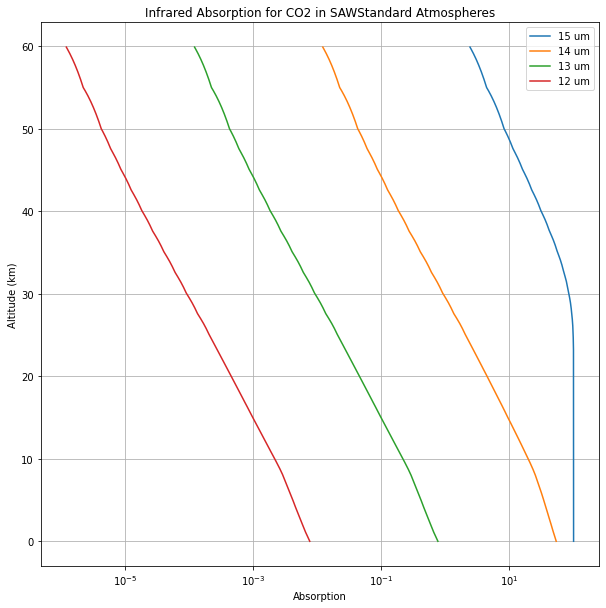

In [341]:
fig, ax = plt.subplots(figsize=(10,10))

stdatm.plot(ax=ax, x='A_15', y='altitude', logx=True)
stdatm.plot(ax=ax, x='A_14', y='altitude', logx=True)
stdatm.plot(ax=ax, x='A_13', y='altitude', logx=True)
stdatm.plot(ax=ax, x='A_12', y='altitude', logx=True)
ax.grid()
ax.set_xlabel('Absorption');
ax.set_ylabel('Altitude (km)');
ax.set_title('Infrared Absorption for CO2 in ' + stdatm_name + 'Standard Atmospheres');
ax.legend(['15 um','14 um','13 um','12 um']);

### Absorption by the entire atmosphere

In [342]:
# Print results
print(f'Total absorption in atmosphere (%) at 15 um = {(1 - Ttotal_15)*100:.2f} %')
print(f'Total absorption in atmosphere (%) at 14 um = {(1 - Ttotal_14)*100:.2f} %')
print(f'Total absorption in atmosphere (%) at 13 um = {(1 - Ttotal_13)*100:.2f} %')
print(f'Total absorption in atmosphere (%) at 12 um = {(1 - Ttotal_12)*100:.2f} %')

Total absorption in atmosphere (%) at 15 um = 100.00 %
Total absorption in atmosphere (%) at 14 um = 100.00 %
Total absorption in atmosphere (%) at 13 um = 44.24 %
Total absorption in atmosphere (%) at 12 um = 0.58 %
